In [34]:
%%html
<style>
.output_wrapper, .output {
    height:auto !important;
    max-height:10000px;  /* your desired max-height here */
}
.output_scroll {
    box-shadow:none !important;
    webkit-box-shadow:none !important;
}
</style>

In [35]:
#EXERCISE 2

In [36]:
import wrds
db=wrds.Connection(wrds_username='sevogel')
from datetime import datetime
db.create_pgpass_file()



data=db.raw_sql("select  permco, date,ret "
           "from crsp.dsf "
           "where permco in (7,35048,8048,21446,20792) "
           "and date>='1999-12-31'"
            "and date<='2019-12-31'")
data.to_csv('data.csv', sep=';', index=False)

Loading library list...
Done


Exception during reset or similar
Traceback (most recent call last):
  File "/Users/sebastianvogel/anaconda3/lib/python3.6/site-packages/sqlalchemy/pool.py", line 709, in _finalize_fairy
    fairy._reset(pool)
  File "/Users/sebastianvogel/anaconda3/lib/python3.6/site-packages/sqlalchemy/pool.py", line 880, in _reset
    pool._dialect.do_rollback(self)
  File "/Users/sebastianvogel/anaconda3/lib/python3.6/site-packages/sqlalchemy/engine/default.py", line 457, in do_rollback
    dbapi_connection.rollback()
psycopg2.OperationalError: SSL connection has been closed unexpectedly



Enter your WRDS username [sebastianvogel]:sevogel
Enter your password:········


In [37]:
from datetime import datetime
import pandas as pd
data = pd.read_csv("data.csv", sep=';')   
#data['date']=pd.to_datetime(data['date'], format='%Y-%m-%d')


data.loc[data.permco ==7, 'ticker'] = 'AAPL' 
data.loc[data.permco ==35048, 'ticker'] = 'GS' 
data.loc[data.permco ==8048, 'ticker'] = 'MSFT' 
data.loc[data.permco ==21446, 'ticker'] = 'PG' 
data.loc[data.permco ==20792, 'ticker'] = 'GE' 
del data['permco']
data=data.set_index(['date','ticker'])
data_win=data[abs(data['ret']) < 0.04]



 Simple and windsorized mean and variance:


,Mean,Variance,Wind.Mean,Wind.Variance
ticker,,,,
AAPL,0.001242,0.000646,0.000827,0.000257
GE,0.000014,0.000391,-0.000003,0.000189
GS,0.000489,0.000531,0.000348,0.000230
MSFT,0.000463,0.000360,0.000382,0.000190
PG,0.000360,0.000174,0.000379,0.000109


/Users/sebastianvogel/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


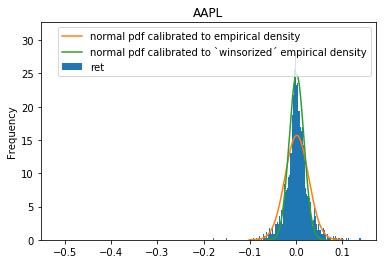

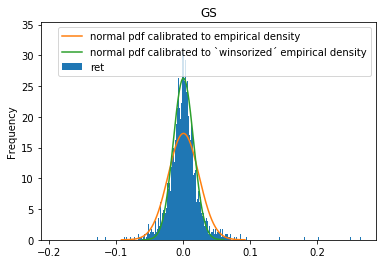

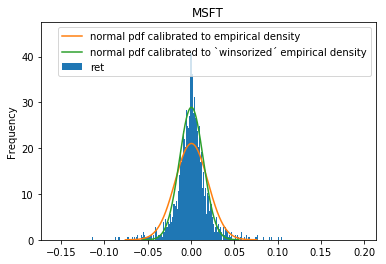

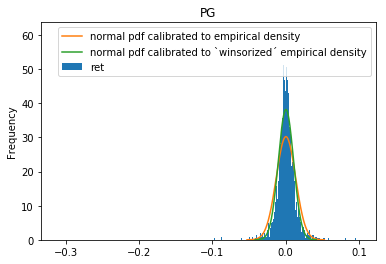

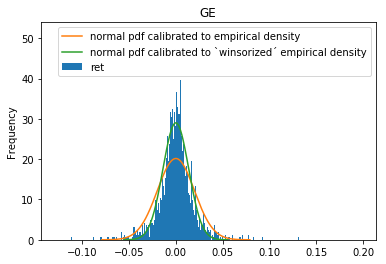


 95% VaR and 99% Var (empirical + normal r.v. with moments matched to empirical distribution):


,95%,99%,95% Normal,99% Normal
ticker,,,,
AAPL,-3.73%,-6.39%,-4.06%,-5.79%
GE,-2.99%,-5.63%,-3.25%,-4.60%
GS,-3.36%,-5.98%,-3.74%,-5.31%
MSFT,-2.81%,-5.42%,-3.07%,-4.37%
PG,-1.74%,-3.42%,-2.13%,-3.03%


In [38]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt

from scipy.stats import norm


S=['AAPL','GS','MSFT','PG','GE']



#(b) Compute the annualized empirical mean and variance of returns
dt=1.0/252.0 #the data is daily
dt=1.0 #the data is daily
df_stats = pd.DataFrame({'Mean' : data.groupby(pd.Grouper(level='ticker'))['ret'].mean()/dt, 
                       'Variance' : data.groupby(pd.Grouper(level='ticker'))['ret'].var()/dt,
                       'Wind.Mean' : data_win.groupby(pd.Grouper(level='ticker'))['ret'].mean()/dt, 
                       'Wind.Variance' : data_win.groupby(pd.Grouper(level='ticker'))['ret'].var()/dt
                      })

print('\n Simple and windsorized mean and variance:')
display(df_stats)

#Define the normal pdf
def normdens(x,m,s2):
    return np.exp(-0.5*(x-m)**2/s2)/np.sqrt(2*np.pi*s2)

# Compute the empirical distribution function for each stock
for stock in S:
    data.iloc[data.index.get_level_values('ticker') == stock].plot.hist(bins=1000,normed=True,label='empirical density')
    x=np.linspace(-4*np.sqrt(df_stats.loc[stock]['Variance']*dt),+4*np.sqrt(df_stats.loc[stock]['Variance']*dt),500)
    y=normdens(x,df_stats.loc[stock]['Mean']*dt,df_stats.loc[stock]['Variance']*dt)
    plt.plot(x,y,label='normal pdf calibrated to empirical density')
    x=np.linspace(-4*np.sqrt(df_stats.loc[stock]['Wind.Variance']*dt),+4*np.sqrt(df_stats.loc[stock]['Wind.Variance']*dt),500)
    y=normdens(x,df_stats.loc[stock]['Wind.Mean']*dt,df_stats.loc[stock]['Wind.Variance']*dt)
    plt.plot(x,y,label='normal pdf calibrated to `winsorized´ empirical density')
    plt.title(stock)
    plt.legend()
    plt.show()
    

# Compute the 95% and 99% VaR
VaR = pd.DataFrame({'95%' : data.groupby(pd.Grouper(level='ticker'))['ret'].quantile(0.05), 
                    '99%' : data.groupby(pd.Grouper(level='ticker'))['ret'].quantile(0.01),
                    '95% Normal' : norm.ppf(0.05, df_stats['Mean']*dt, np.sqrt(df_stats['Variance']*dt)), 
                    '99% Normal' : norm.ppf(0.01, df_stats['Mean']*dt, np.sqrt(df_stats['Variance']*dt)) 
                      })
print('\n 95% VaR and 99% Var (empirical + normal r.v. with moments matched to empirical distribution):')
#VaR= VaR.set_index(S)
display(VaR.style.format("{:.2%}"))





--------------------------------------------------
We notice that the normal distribution 
does not characterize appropriately the distribution 
of daily stock returns.
If we include all returns,
the distribution does not fit well
the center of the distribution:
It overestimates the probability
of moderate moves.
This can also be seen from the fact
that the calibrated normal distribution 
overestimates the 95%-VaR
(but underestimates the 99%-VaR).

On the other hand,
if we winsorize the data
by filtering out the "extreme moves",
we fit well the center of the distribution
but significantly underestimate 
the probability of large moves.
This difficulty arises from the fact that
the distribution of daily stock returns
are characterized by "fat tails":
large daily returns occur much more frequently 
than the normal distribution would predict.

A better model of daily stock returns
would have a "diffusion" part 
(for example, a geometric brownian motion)
which would be calibrated to match
the returns excluding large swings.
Then, we would account separately
for the large but infrequent swings
by adding jumps to the stochastic process.
Such models are called
"jump-diffusion models".


In [40]:
# Compute the 95% and 99% Expected shortfall
VaR95=norm.ppf(0.05, df_stats['Mean']*dt, np.sqrt(df_stats['Variance']*dt)), 
VaR99=norm.ppf(0.01, df_stats['Mean']*dt, np.sqrt(df_stats['Variance']*dt)), 
ES95=df_stats['Mean']*dt-np.sqrt(df_stats['Variance']*dt)*norm.pdf(norm.ppf(0.05,0,1))/norm.cdf(norm.ppf(0.05,0,1))
ES99=df_stats['Mean']*dt-np.sqrt(df_stats['Variance']*dt)*norm.pdf(norm.ppf(0.01,0,1))/norm.cdf(norm.ppf(0.01,0,1))

VaR95emp=data.groupby('ticker')['ret'].quantile(0.05)
VaR99emp=data.groupby(pd.Grouper(level='ticker'))['ret'].quantile(0.01)


data1=pd.merge(data,VaR95emp, how='left', on='ticker')
data1=data1.rename(columns={"ret_y": "VaR95"})
data1=pd.merge(data1,VaR99emp, how='left', on='ticker')
data1=data1.rename(columns={"ret": "VaR99"})
data1=data1.rename(columns={"ret_x": "ret"})


In [71]:

ES95_emp=data1[data1['ret']<data1['VaR95']].groupby(pd.Grouper(level='ticker'))['ret'].mean()
ES99_emp=data1[data1['ret']<data1['VaR99']].groupby(pd.Grouper(level='ticker'))['ret'].mean()

ES = pd.DataFrame({'95%' : ES95_emp, 
                    '99%' : ES99_emp,
                    '95% Normal' : ES95, 
                    '99% Normal' : ES99 
                      })
print('\n 95% ES and 99% ES (empirical + normal r.v. with moments matched to empirical distribution):')
#VaR= VaR.set_index(S)
display(ES.style.format("{:.2%}"))


 95% ES and 99% ES (empirical + normal r.v. with moments matched to empirical distribution):


,95%,99%,95% Normal,99% Normal
AAPL,-5.64%,-9.37%,-5.12%,-6.65%
GE,-4.69%,-7.74%,-4.08%,-5.27%
GS,-5.14%,-8.75%,-4.71%,-6.09%
MSFT,-4.39%,-7.43%,-3.87%,-5.01%
PG,-3.03%,-5.55%,-2.69%,-3.48%
